# This notebook tries to understand the get_started notebook provided in porepy

The tutorial investigates how to solve single-phase flow using PorePy.
Mathematically, single-phase flow may be described as
$$-\nabla\cdot K \nabla p = f$$
with boundary conditions on $\partial \Omega_d$ and $\partial \Omega_n$, the respective boundaries of $\Omega_d$ and $\Omega_n$. 

The boundary conditions are written mathematically as:
$$p=p_b, \quad -K\nabla p \cdot \mathbf{n} = u_b$$

 Here, $f$ is a scalar source/sink term, $ĸ$ is a permeability matrix, $p_b$ is the pressure at the boundary (Dirichlet), $u_p$ is the flux at the boundary (Neumann).
 
 The simplest example, presented in get_started.ipynb sets,
 
 $$\Omega = [0,1]^2, \quad \partial \Omega_d = \partial \Omega,\quad \partial \Omega_n = \emptyset$$
 with data: 
 $$f=1,\quad K=I, \quad \text{ and }\quad  p_b=0$$
 
 ## Let's get started!
 as the get_started notebook describes, to run this example, four modules and classes are required from PorePy:
 
 * `plot_grid` plots the grid and the solution using Matplotlib;
 * `tensor` is used to declare the permeability;
 * `BoundaryCondition` handles the information useful for the boundary conditions;
 * `Parameters` contains physical data for the problem.
 
 In addition, the python libraries `numpy` and `scipy.sparse` are needed.

In [1]:
import numpy as np
import scipy.sparse as sps
import porepy as pp

# Step 1: Create a grid.

Creation of grids in this example is supported by the CartGrid class.
The physical location of the CartGrid class is: `src > porepy > grids > structured.py`.
The CartGrid class inheritance structure is: `CartGrid <-- TensorGrid <-- Grid (<-- object)`.

##### Properties of the CartGrid class
A CartGrid instance defines a 2D or 3D Cartesian grid. A grid of this form is defined by coordinates on two or three orthogonal axes as we are used to from calculus.

An instance of a CartGrid is initiated by an `np.array`, `nx`, and optionally an `np.array`, `physdims`.
`nx` will either be a vector of two or three numbers, depending on whether the problem posed is two or three dimensions.
The parameter denotes the number of cells in each direction.
The optional parameter `physdims` relates the grid to the physical dimensions in each direction. By default, `physdims = nx`.

When CartGrid is provided `nx` either as a float (1D), 2D array or 3D array, the construction is sent to `TensorGrid`.
##### Properties of the TensorGrid class
A TensorGrid instance defines a grid formed by a tensor product of line point distributions.

## Basic setup of grid
Creating a grid is really easy. In its simplest form, we input two parameters to initialize an instance of CartGrid. `nx` (first positional parameter) determines the number of cells in each direction.
The second positional parameter, `physdims` relates the mesh to physical dimensions.
Throughout this notebook, I will use `physdims=[1,1]`, i.e. $\Omega = [0,1]^2$ for simplicitly.

The example from get_started initializes the following grid:

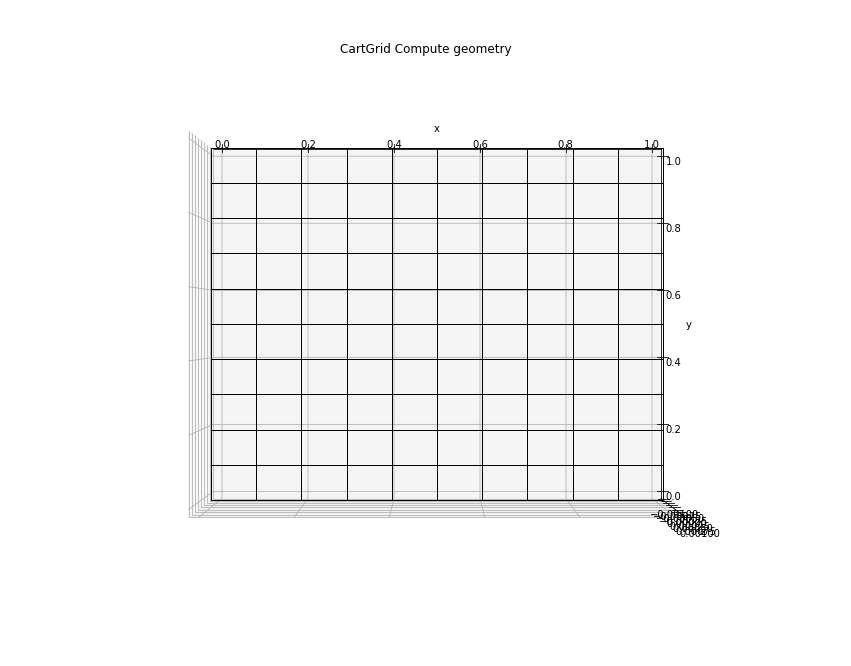

In [70]:
Nx = Ny = 10
g = pp.CartGrid([Nx,Ny], [1,1])
g.compute_geometry()
pp.plot_grid(g, alpha=0, figsize=(15,12))

## Refine mesh size
Refining the mesh size is simple. We initialize a new instance of CartGrid with the first parameter, `nx` changed.
So, for instance, if we wish to double the number of cells in each dimension we could do the following:

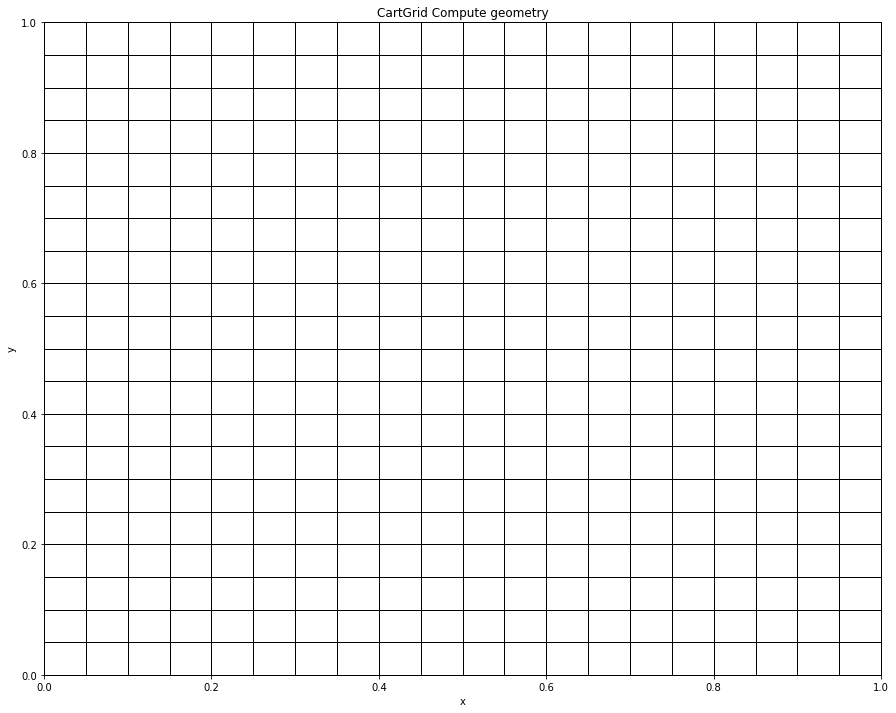

In [60]:
Nx = Ny = 20
g = pp.CartGrid([Nx,Ny], [1,1])
g.compute_geometry()
pp.plot_grid(g, alpha=0, figsize=(15,12), plot_2d=True)

### Note:
When doing this, I am creating a new instance of the class. For a Cartesian grid, this seems to be quick and convenient, however for other grid types it may be more computationally efficient to change the parameters of the existing instance and then call `g.compute_geometry`.

Note a comment under `def compute_geometry(self)` on the matter:
```
"The method could have been called from the constructor, however, in cases where the grid is modified after the initial construction (say, grid refinement), this may lead to costly, unnecessary computations."
```
It is not clear to me how to modify the construction of a CartGrid without initializing a new class after looking at the structure of the code.

---
For the rest of the notebook, we use this simple grid:

In [33]:
Nx = Ny = 10
g = pp.CartGrid([Nx,Ny], [1,1])
g.compute_geometry()

# Step 2: Define problem data
The data in PorePy are piecewise constant in their respective domain (cells or faces).

Recall, we are trying to solve $-\nabla\cdot K \nabla p = f$. The pre-determined parameters are $K$, the permeability matrix and $f$, a scalar source/sink term.

### The permeability matrix
Depending on the problem at hand, the permeability matrix, $K$ will have different characteristics. Common for all $K$ is that it is a symmetric, positive definite second-tensor.

Two important characterizing features of a problem are *heterogeneity* and *anisotropy*.

**_Homogeneous_** In a homogeneous medium, properties $(\phi, K)$ are independent of the position within the medium.

**_Heterogenous_** Otherwise, properties depend on the position within the medium. $(\underline{\underline{K}} = \underline{\underline{K}}(\underline{x}))$

**_Isotropic_** In an isotropic medium, properties does not depend on directions. (i.e. $K_{xx}=K_{yy}=K_{zz}$ and $\underline{\underline{K}} = K \underline{\underline{I}}$)

**_Anisotropic_** Otherwise, a property depends on the directions. ($K_{xx}\neq K_{yy}\neq K_{zz}$)


 ## Create permeability matrix
The easiest way to create an identity tensor, i.e. $K_{xx}=K_{yy}=K_{zz}=1$ ($K_{ij}=0$ for $i\neq j$) is:

In [34]:
perm = pp.SecondOrderTensor(np.ones(g.num_cells))

Here we see illustrated one of several entities that `g.compute_geometry()` computes.
From the documentation, `g.compute_geometry()` also computes the following:

```
face_areas (np.ndarray): Areas of all faces
face_centers (np.ndarray): Centers of all faces. Dimensions dim x num_faces
face_normals (np.ndarray): Normal vectors of all faces. Dimensions dim x num_faces. See also cell_faces.
cell_centers (np.ndarray): Centers of all cells. Dimensions dim x num_cells
cell_volumes (np.ndarray): Volumes of all cells
```

This description illuminates the next few lines in the code too:

In [35]:
Omega_1 = g.cell_centers[0, :] < 0.5

kxx, kyy, kxy = 1e2*np.ones(g.num_cells), np.ones(g.num_cells), 8*np.ones(g.num_cells)
kxx[Omega_1] = np.ones(np.sum(Omega_1))
kyy[Omega_1] = 1e2*np.ones(np.sum(Omega_1))
perm = pp.SecondOrderTensor(kxx=kxx, kyy=kyy, kxy=kxy)                              
f = g.cell_volumes

---
Let's break down the above code block.

`Omega_1` defines the region $\Omega_1$ as all cells where the x-coordinate of their cell centers are less than 0.5.

The next lines, 
```
kxx, kyy, kxy = 1e2*np.ones(g.num_cells), np.ones(g.num_cells), 8*np.ones(g.num_cells)
kxx[Omega_1] = np.ones(np.sum(Omega_1))
kyy[Omega_1] = 1e2*np.ones(np.sum(Omega_1))
```
defines $K_{xx}, K_{yy}. K_{xy}$. The first line initially defines the permeability matrix to be identical throughout the grid, but with different values in each cardinal direction. In other words, an anisotropic homogeneous permeability matrix.

However, the next two lines re-defines the entries $K_{xx}, K_{yy}$ in the region $\Omega_1$. In $\Omega_1$, $K_{xx}$ now assumes a low value, 1, while $K_{yy}$ assumes a large value, 100.
Note that the value of $K_{xx}\in \Omega_1$ equals $K_{yy}\notin\Omega_1$ and $K_{yy}\in \Omega_1$ equals $K_{xx}\notin\Omega_1$.

Finally, the permeability matrix is assembled:
```
perm = pp.SecondOrderTensor(kxx=kxx, kyy=kyy, kxy=kxy).
```

Lastly, 
```
f = g.cell_volumes
``` 
defines the source term $f$ to be constant throughout the domain. (_Note_ that the cell volumes are equal in this grid, but even if they were not, this definition would ensure "equality" since larger cells should naturally a larger source term.)

## Impose boundary conditions


Boundary conditions are defined through the `BoundaryCondition` class. The boundaries are flagged either `'dir'` for Dirichlet, `'neu'` for Neumann or `'rob'` for Robin. (If Robin is chosen, weights should also be selected).

Intuitively, imposing e.g. $-K\nabla p \cdot \mathbf{n} = 0$ ($\mathbf{n}$ is the outward normal) gives an isolated boundary where no flow can enter or exit through the prescribed boundary.
On the other hand, adding a Dirichlet condition on a side, is prescribing some constant pressure along that boundary.

In [37]:
b_faces = g.tags['domain_boundary_faces'].nonzero()[0]

labels = np.array(['dir']*b_faces.size)
labels[g.face_centers[1, b_faces] == 1.] = 'neu'

bc = pp.BoundaryCondition(g, b_faces, labels)

bc_val = np.zeros(g.num_faces)
bottom = b_faces[g.face_centers[1, b_faces] == 0.]
bc_val[bottom] = np.ones(bottom.size)

For the domain under consideration, we can find which faces are the boundary faces by searching the 'tags' of the faces:
```
b_faces = g.tags['domain_boundary_faces'].nonzero()[0]
```
In this example, we initially set all faces to Dirichlet:
```
labels = np.array(['dir']*b_faces.size)
```
Then, relabled the faces with $(x,y)=(x,1)$ as Neumann:
```
labels[g.face_centers[1, b_faces] == 1.] = 'neu'
```
Finally, we create a `BoundaryCondition` object with the information above:
```
bc = pp.BoundaryCondition(g, b_faces, labels)
```
After this, we choose the actual data for the boundary conditions:
```
bc_val = np.zeros(g.num_faces)
bottom = b_faces[g.face_centers[1, b_faces] == 0.]
bc_val[bottom] = np.ones(bottom.size)
```
Here, every face (also non-boundary faces) has data, initially set to 0. Then, the bottom boundary, $(x,y)=(x,0)$ is set to 1.

In summary, the side boundaries has Dirichlet condition at 0, the top has Neumann at 0 and the bottom has Dirichlet at 1.

**I Don't quite understand the BC conditions (Do some testing!)**^^^

Finally, all the initial data and parameters are passed through a method `initialize_default_data` for a `"flow"` type problem:
```
specified_parameters = {"second_order_tensor": perm, "source": f, "bc": bc, "bc_values": bc_val}
data = pp.initialize_default_data(g, {}, "flow", specified_parameters)
```

In [38]:
specified_parameters = {"second_order_tensor": perm, "source": f, "bc": bc, "bc_values": bc_val}
data = pp.initialize_default_data(g, {}, "flow", specified_parameters)

# Step 3: Problem solution
This problem is solved using a two-point flux approximation.

The class `Tpfa` provides us with the matrix and right-hand side, $A, b$. Then, we may use a regular sparse solver on the system.

In [39]:
solver = pp.Tpfa("flow")
solver.discretize(g, data)
A, b = solver.assemble_matrix_rhs(g, data)
p = sps.linalg.spsolve(A, b)

## Visualization
At last, we can visualize the result!

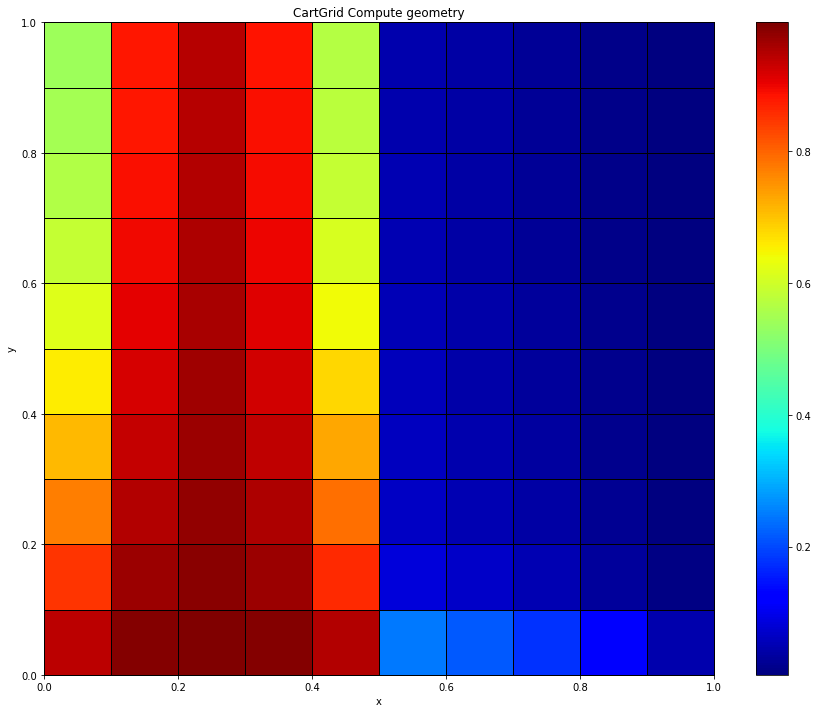

In [59]:
pp.plot_grid(g, p, figsize=(15, 12), plot_2d=True)